# Metapath Rank Comparison
Compare the rankings the unsupervised methods in hetmech assign to different epilepsy/drug metapaths to the supervised ones from rephetio

In [1]:
import math

from matplotlib import pyplot as plt
import pandas
import plotnine as p9
from scipy import stats

import sys
sys.path.append("..")
from src.database_utils import get_db_connection

In [2]:
%%time
epilepsy_id = 'DOID:1826'
# Get top ten most important metapaths for epilepsy (which are all compound-disease pairs)
query = f'''
SELECT
  outer_pc.dwpc AS dwpc,
  outer_pc.p_value AS p_value,
  outer_pc.metapath_id AS metapath_id, 
  top_ids.source_name AS source_name,
  top_ids.source_identifier AS source_identifier, 
  top_ids.target_name AS target_name,
  top_ids.target_identifier AS target_identifier
FROM 
    (SELECT dwpc, p_value, metapath_id, source_id, target_id, n1.name AS source_name, n1.identifier AS source_identifier,
            n2.name AS target_name, n2.identifier AS target_identifier
     FROM dj_hetmech_app_pathcount pc 
     JOIN dj_hetmech_app_node join_node  
         ON pc.target_id=join_node.id OR pc.source_id=join_node.id
     JOIN dj_hetmech_app_node n1 
         ON pc.source_id = n1.id 
     JOIN dj_hetmech_app_node n2 
         ON pc.target_id = n2.id     
     WHERE join_node.identifier='{epilepsy_id}' AND (n1.metanode_id = 'Compound' OR n2.metanode_id = 'Compound')
     ORDER BY pc.p_value) AS top_ids 
JOIN dj_hetmech_app_pathcount outer_pc 
     ON (top_ids.source_id = outer_pc.source_id AND 
         top_ids.target_id = outer_pc.target_id) OR 
         (top_ids.source_id = outer_pc.target_id AND 
         top_ids.target_id = outer_pc.source_id)
ORDER BY outer_pc.p_value;
'''
with get_db_connection() as connection:
    metapaths = pandas.read_sql(query, connection)

CPU times: user 1.45 s, sys: 350 ms, total: 1.8 s
Wall time: 11.4 s


In [3]:
metapaths = metapaths.sort_values(by=['source_name', 'metapath_id'])

# Ensure that you only have one copy of each (source_name, metapath_id) pair
metapaths = metapaths.drop_duplicates(subset=['source_name', 'metapath_id'])

# Remove any rows with NaN values
metapaths = metapaths.dropna()

min_p_value = metapaths[metapaths.p_value != 0].p_value.min()

metapaths.loc[metapaths.p_value == 0, 'p_value'] = min_p_value

metapaths['neg_log_p_value'] = metapaths.p_value.apply(lambda x: -math.log10(x))

metapaths.head()

,dwpc,p_value,metapath_id,source_name,source_identifier,target_name,target_identifier,neg_log_p_value
45882,3.870881,0.010753,CbGaD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,1.968488
453568,0.999700,0.699814,CbGbCtD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,0.155017
36591,2.771277,0.006504,CbGdAlD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,2.186818
271712,0.722720,0.265726,CbGeAlD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,0.575565
223994,1.757313,0.188744,CbGr>GaD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,0.724127


In [4]:
%%time
path = 'https://github.com/dhimmel/learn/raw/8792c2e408e790cd8d77adb34d013961f4d5c4f0/prediction/predictions/term-contribution.tsv.bz2'
supervised_df = pandas.read_table(path)

CPU times: user 1.95 s, sys: 16.4 ms, total: 1.96 s
Wall time: 2.93 s


In [5]:
supervised_df = supervised_df[supervised_df['disease_id'] == epilepsy_id]
supervised_df.head()

,compound_id,disease_id,degree_CrC,degree_CiPC,dwpc_CiPCiCdGaD,dwpc_CbGdDdGaD,dwpc_CrCuGaDrD,dwpc_CrCdGiGaD,dwpc_CrCuG<rGaD,dwpc_CrCdGeAlD,...,dwpc_CbGeAlD,dwpc_CbGpPWpGaD,dwpc_CpDpCtD,dwpc_CcSEcCtD,dwpc_CrCrCtD,dwpc_CtDrD,dwpc_CrCtD,dwpc_CiPCiCtD,dwpc_CbGaD,dwpc_CbGbCtD
72286,DB01048,DOID:1826,0.111440,-0.102150,-0.040193,-0.208570,0.038024,-0.033015,-0.052731,-0.002373,...,0.004246,0.073912,-0.005732,0.22699,-0.020583,-0.016584,-0.016985,-0.016315,0.787420,0.13442
72287,DB05812,DOID:1826,0.203590,0.055180,0.020172,-0.048846,0.038024,-0.034870,-0.024648,-0.002319,...,0.004713,0.084627,-0.005732,0.19159,-0.020583,-0.016584,-0.016985,-0.016315,0.301050,0.60479
72288,DB00659,DOID:1826,0.348030,0.055180,0.020172,-0.101200,0.038024,0.029401,0.028710,0.028621,...,0.116910,0.212720,-0.005732,0.28682,-0.020583,-0.016584,-0.016985,-0.016315,0.904550,0.99410
72289,DB00284,DOID:1826,-0.060377,-0.040893,0.020172,0.039024,0.038024,-0.005460,-0.011213,0.014113,...,0.114250,0.112020,-0.005732,0.14137,-0.020583,-0.016584,-0.016985,-0.016315,-0.070953,-0.11410
72290,DB01193,DOID:1826,-0.158930,0.055180,0.020172,-0.105240,0.038024,-0.099003,-0.061824,-0.045351,...,0.003554,0.082441,-0.005732,0.23538,-0.020583,-0.016584,-0.016985,-0.016315,0.337920,0.31866


In [6]:
reformatted_supervised_df = pandas.melt(
    frame=supervised_df,
    id_vars=['compound_id', 'disease_id'], 
    var_name='metapath_id',
    value_name='metapath_weight',
)
reformatted_supervised_df.head()

,compound_id,disease_id,metapath_id,metapath_weight
0,DB01048,DOID:1826,degree_CrC,0.111440
1,DB05812,DOID:1826,degree_CrC,0.203590
2,DB00659,DOID:1826,degree_CrC,0.348030
3,DB00284,DOID:1826,degree_CrC,-0.060377
4,DB01193,DOID:1826,degree_CrC,-0.158930


In [7]:
# Drop all rows with negative or zero weights
positive_supervised_df = reformatted_supervised_df[(reformatted_supervised_df['metapath_id'].str.contains('dwpc_')) & 
                                                   (reformatted_supervised_df['metapath_weight'] > 0)].copy()

positive_supervised_df['metapath_id'] = reformatted_supervised_df['metapath_id'].str.replace('dwpc_', '')

# Remove CtDrD, there are only 7 results in the merged dataset and they break the loess curves later
positive_supervised_df = positive_supervised_df[~ positive_supervised_df['metapath_id'].str.contains('CtDrD')]

# It's worth noting that there aren't any length one paths in the term contributions dataset
positive_supervised_df.head()

,compound_id,disease_id,metapath_id,metapath_weight
3077,DB05812,DOID:1826,CiPCiCdGaD,0.020172
3078,DB00659,DOID:1826,CiPCiCdGaD,0.020172
3079,DB00284,DOID:1826,CiPCiCdGaD,0.020172
3080,DB01193,DOID:1826,CiPCiCdGaD,0.020172
3081,DB01418,DOID:1826,CiPCiCdGaD,0.020172


In [8]:
merged_df = metapaths.merge(
    positive_supervised_df,
    left_on=['metapath_id', 'source_identifier', 'target_identifier'],
    right_on=['metapath_id', 'compound_id', 'disease_id'],
)
merged_df.head()

,dwpc,p_value,metapath_id,source_name,source_identifier,target_name,target_identifier,neg_log_p_value,compound_id,disease_id,metapath_weight
0,3.870881,0.010753,CbGaD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,1.968488,DB01048,DOID:1826,0.787420
1,0.999700,0.699814,CbGbCtD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,0.155017,DB01048,DOID:1826,0.134420
2,0.722720,0.265726,CbGeAlD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,0.575565,DB01048,DOID:1826,0.004246
3,2.743718,0.003349,CcSEcCtD,Abacavir,DB01048,epilepsy syndrome,DOID:1826,2.475071,DB01048,DOID:1826,0.226990
4,1.169552,0.460588,CbGaD,Abiraterone,DB05812,epilepsy syndrome,DOID:1826,0.336687,DB05812,DOID:1826,0.301050


Text(0, 0.5, 'Rephetio Metapath Weight')

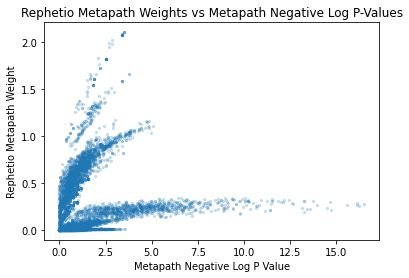

In [9]:
plt.scatter(merged_df.neg_log_p_value, merged_df.metapath_weight, alpha=.2, s=5)
plt.title('Rephetio Metapath Weights vs Metapath Negative Log P-Values')
plt.xlabel('Metapath Negative Log P Value')
plt.ylabel('Rephetio Metapath Weight')

Text(0, 0.5, 'Rephetio Metapath Weight')

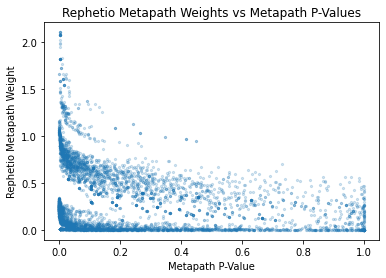

In [10]:
plt.scatter(merged_df.p_value, merged_df.metapath_weight, alpha=.2, s=5)
plt.title('Rephetio Metapath Weights vs Metapath P-Values')
plt.xlabel('Metapath P-Value')
plt.ylabel('Rephetio Metapath Weight')

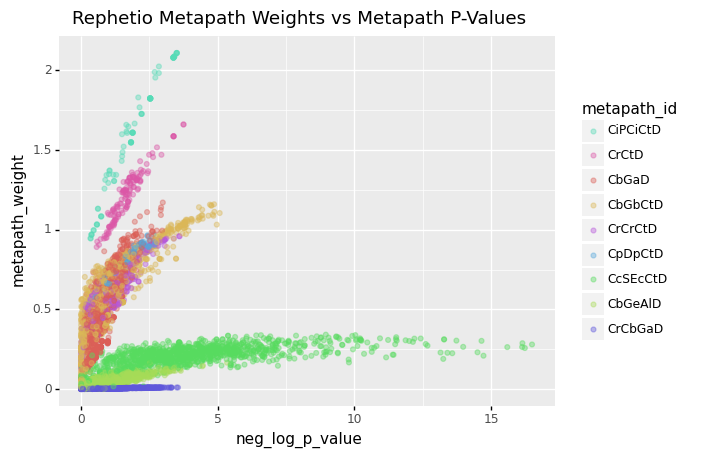

<ggplot: (8743275433048)>

In [11]:
colors = p9.scale_color_hue().palette(9)
show_metapaths = ['CiPCiCtD', 'CrCtD', 'CbGaD', 'CbGbCtD', 'CrCrCtD', 'CpDpCtD', 'CcSEcCtD', 'CbGeAlD', 'CrCbGaD']
(
    p9.ggplot(merged_df)
    + p9.geom_point(p9.aes('neg_log_p_value', 'metapath_weight', color='metapath_id'), alpha=.4)
    + p9.scale_color_manual(colors, breaks=show_metapaths)
    + p9.ggtitle('Rephetio Metapath Weights vs Metapath P-Values')
)

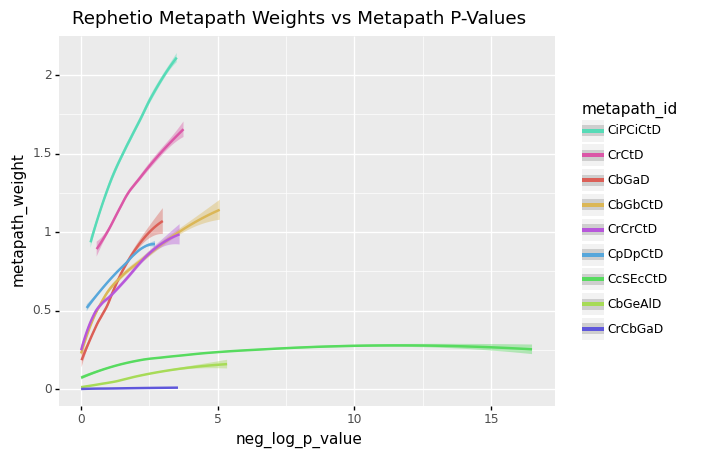

<ggplot: (8743280011909)>

In [12]:
(
    p9.ggplot(merged_df, p9.aes('neg_log_p_value', 'metapath_weight', color='metapath_id', fill='metapath_id')) 
    + p9.geom_smooth(method="loess")
    + p9.scale_color_manual(colors, breaks=show_metapaths)
    + p9.ggtitle('Rephetio Metapath Weights vs Metapath P-Values')
    + p9.guides(fill=False)
)